In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

In [2]:
# Load data
cities = pd.read_csv('Nomad.csv')
cities.drop(columns='Unnamed: 0', inplace=True)

# Separate features and targets
y = cities['Total_Score']
X = cities.drop(columns=['Total_Score', 'City', 'Rank', 'Unliked_By_Members', 
                         'Temperature_now_celcius', 'Temperature_now_Feels_Like_Celcius'])

# Fix a few columns
cities['Liked_By_Members'] = cities['Liked_By_Members'].fillna(0)
cities['Cost'] = cities['Cost'].str.replace(',','')
cities['Cost'] = cities.Cost.astype(int)
cities['Income_Level'] = cities['Income_Level'].str.replace(',','')
cities['Income_Level'] = cities.Income_Level.astype(int)

In [3]:
# Data preprocessing
numeric_features = X.select_dtypes(include=['int32', 'int64', 'float64']).columns
categor_features = X.select_dtypes(include=['object']).columns

numeric_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categor_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_encoder, numeric_features),
        ('categor', categor_encoder, categor_features)])

X_preprocessed = preprocessor.fit_transform(X)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.1, random_state=478)

## Linear Model

In [4]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

## Models

In [5]:
# Cross validation to tune model parameters
models = {
    'Random Forest': RandomForestRegressor(
        random_state=478
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        random_state=478
    ),
    'Neural Network': MLPRegressor(
        random_state=478, max_iter=3000, early_stopping=True
    )
}
param_grids = {
    'Random Forest': {'n_estimators': [10, 50, 100, 250]},
    
    "Gradient Boosting": {"max_depth": [3, 5, 7], 
                          "learning_rate": [0.01, 0.1, 0.5],
                          "n_estimators": [50, 100, 500]},
    
    'Hist Gradient Boosting': {'max_iter': [10, 50, 100, 500]},
    
    'Neural Network': {'alpha': [0.0001, 0.001, 0.01],
                       'hidden_layer_sizes': [(100,), 
                                              (10,10,10,10,10), 
                                              (100,100,100,100,100), 
                                              (10,10,10,10,10,10,10,10)]}
}
cv = KFold(n_splits=6, shuffle=True, random_state=478)

tuning_results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train, y_train)
    result = {'model': name, 'cv_results': pd.DataFrame(grid_search.cv_results_)}
    tuning_results.append(result)

In [6]:
# Put all the models fit in one place for later evaluation
best_models = {}
best_models['Linear Regression'] = reg_model   # Add the linear model fit earlier

# Select and fit the best models according to CV parameter tuning
for result in tuning_results:
    model_name = result['model']
    cv_results = result['cv_results']
    
    best_index = cv_results['mean_test_score'].idxmax()
    best_params = cv_results.loc[best_index]['params']
    best_model = models[model_name].set_params(**best_params)
    
    best_model.fit(X_train, y_train)
    best_models[model_name] = best_model
    
best_models

{'Linear Regression': LinearRegression(),
 'Random Forest': RandomForestRegressor(n_estimators=50, random_state=478),
 'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, random_state=478),
 'Neural Network': MLPRegressor(early_stopping=True,
              hidden_layer_sizes=(10, 10, 10, 10, 10, 10, 10, 10), max_iter=3000,
              random_state=478)}

## Model Evaluation

In [7]:
evaluation_results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result = {
        "Model": model_name,
        "MSE": mse,
        "MAE": mae,
        "R^2": r2
    }
    evaluation_results.append(result)

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

,Model,MSE,MAE,R^2
0,Linear Regression,0.066682,0.187255,0.609881
1,Random Forest,0.027677,0.107644,0.838080
2,Gradient Boosting,0.027534,0.102063,0.838913
3,Neural Network,0.155604,0.293030,0.089649


## Feature Importance

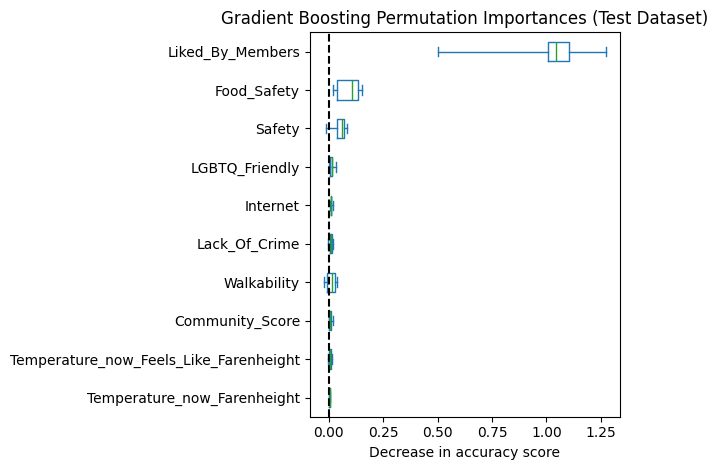

In [8]:
# Gradient Boosting Permutation Importance
gb_model = best_models['Gradient Boosting']

result = permutation_importance(
    gb_model, X_test, y_test, n_repeats=10, random_state=478
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Select the top N most important variables
top_n = 10
top_importances = importances.iloc[:, -top_n:]

ax = top_importances.plot.box(vert=False, whis=10)
ax.set_title("Gradient Boosting Permutation Importances (Test Dataset)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

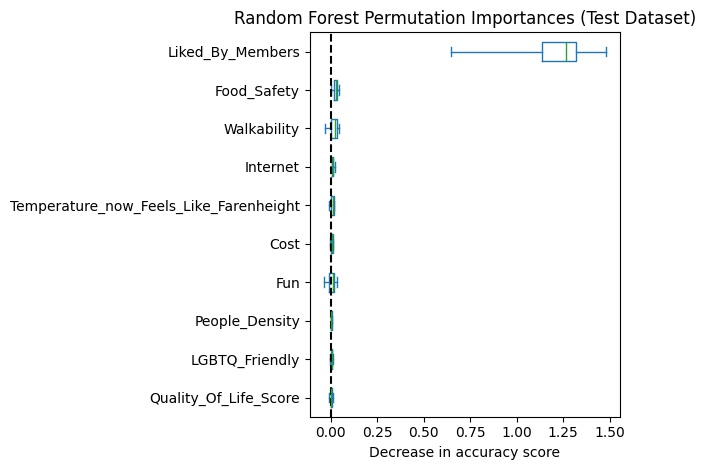

In [9]:
# Random Forest Permutation Importance
rf_model = best_models['Random Forest']

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=478
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Select the top N most important variables
top_n = 10
top_importances = importances.iloc[:, -top_n:]

ax = top_importances.plot.box(vert=False, whis=10)
ax.set_title("Random Forest Permutation Importances (Test Dataset)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## LASSO Regression

In [10]:
import warnings
warnings.filterwarnings('ignore')
Model_results = []

In [11]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

# fit model
Lasso_model = model.fit(X_train, y_train)
sfm = SelectFromModel(Lasso_model, prefit=True)
X_train_selected = sfm.transform(X_train)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)
array = np.where(abs(Lasso_model.coef_) > 0)
print("Variables Selected:")
print(X.iloc[:, [0,  1,  2,  4,  6, 10, 11, 12, 13, 16, 17, 19, 21, 22, 23, 27, 28,
       30, 32, 33, 34, 35] ].columns)
print("Variable Coefficients:")
print(Lasso_model.coef_)

alpha: 0.010000
Variables Selected:
Index(['Liked_By_Members', 'Quality_Of_Life_Score', 'Family_Score', 'Cost',
       'Fun', 'Safety', 'Food_Safety', 'Lack_Of_Crime', 'Lack_Of_Racism',
       'Vulnerability_To_Climate_Change', 'Income_Level', 'People_Density',
       'Peace', 'Traffic_Safety', 'Hospitals', 'Places_To_Work_From',
       'AC_Or_Heating', 'Freedom_Of_Speech', 'LGBTQ_Friendly', 'Startup_Score',
       'Temperature_now_Farenheight',
       'Temperature_now_Feels_Like_Farenheight'],
      dtype='object')
Variable Coefficients:
[ 0.21621134  0.05557228 -0.          0.00974793 -0.         -0.
  0.00262186  0.         -0.16319331  0.06016019 -0.32331945 -0.00049633
 -0.01236661  0.         -0.00763976 -0.00522093 -0.01644896  0.04298973
 -0.00931651 -0.         -0.00158604 -0.01740396  0.00412635  0.02896024
 -0.         -0.          0.         -0.          0.01933624  0.00188942
  0.          0.          0.0460351  -0.          0.          0.0390817 ]


In [12]:
y_pred = Lasso_model.predict(X_test)
Lasso_mse = mean_squared_error(y_test, y_pred)
Lasso_mae = mean_absolute_error(y_test, y_pred)
Lasso_r2 = r2_score(y_test, y_pred)

print(Lasso_mse)
print(Lasso_mae)
print(Lasso_r2)
result = {'model': "Lasso", 'MSE': Lasso_mse, 'MAE': Lasso_mae, 'R^2': Lasso_r2}
Model_results.append(result)

0.05852794433442192
0.1796494666183691
0.6575862644127026


## Ridge Regression

In [13]:
# list of alphas to check: 100 values from 0 to 5 with
r_alphas = np.logspace(0, 5, 100)

# initiate the cross validation over alphas
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2')

# fit the model with the best alpha
ridge_model = ridge_model.fit(X_train, y_train)

print("Variable Names:")
print(X.columns)
print("Variable Coefficients:")
print(ridge_model.coef_)

Variable Names:
Index(['Liked_By_Members', 'Quality_Of_Life_Score', 'Family_Score',
       'Community_Score', 'Cost', 'Internet', 'Fun', 'Humidity_now',
       'Air_Quality_Now', 'Air_Quality_Annual', 'Safety', 'Food_Safety',
       'Lack_Of_Crime', 'Lack_Of_Racism', 'Education_Level', 'Power_Grid',
       'Vulnerability_To_Climate_Change', 'Income_Level', 'English_Speaking',
       'People_Density', 'Walkability', 'Peace', 'Traffic_Safety', 'Hospitals',
       'Happiness', 'Nightlife', 'Free_Wifi_In_City', 'Places_To_Work_From',
       'AC_Or_Heating', 'Friendly_To_Foreigners', 'Freedom_Of_Speech',
       'Female_Friendly', 'LGBTQ_Friendly', 'Startup_Score',
       'Temperature_now_Farenheight',
       'Temperature_now_Feels_Like_Farenheight'],
      dtype='object')
Variable Coefficients:
[ 0.2209978   0.07016438  0.00520533  0.01537689  0.00085474 -0.00715422
  0.06172217 -0.04081746 -0.19466848  0.08284827 -0.30795687 -0.00051047
 -0.017788    0.00770385 -0.03079796 -0.0295514  -0.0

In [14]:
y_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_mae = mean_absolute_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)

print(ridge_mse)
print(ridge_mae)
print(ridge_r2)
result = {'model': "Ridge", 'MSE': ridge_mse, 'MAE': ridge_mae, 'R^2': ridge_r2}
Model_results.append(result)

0.06412181687463697
0.1818396888116643
0.624859695682563


## Elastic Net

In [15]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
ElasticNet_model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

# fit model
ElasticNet_model.fit(X_train, y_train)

# summarize chosen configuration
print('alpha: %f' % ElasticNet_model.alpha_)
print('l1_ratio_: %f' % ElasticNet_model.l1_ratio_)
array = np.where(abs(ElasticNet_model.coef_) >0)
print("Variables Selected:")
print(X.iloc[:, [ 0,  1,  2,  3,  4,  6,  7, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22,
       23, 26, 27, 28, 29, 30, 32, 33, 34, 35]].columns)
print("Variable Coefficients:")
print(ElasticNet_model.coef_)

alpha: 0.010000
l1_ratio_: 0.650000
Variables Selected:
Index(['Liked_By_Members', 'Quality_Of_Life_Score', 'Family_Score',
       'Community_Score', 'Cost', 'Fun', 'Humidity_now', 'Safety',
       'Food_Safety', 'Lack_Of_Crime', 'Lack_Of_Racism', 'Education_Level',
       'Vulnerability_To_Climate_Change', 'Income_Level', 'People_Density',
       'Peace', 'Traffic_Safety', 'Hospitals', 'Free_Wifi_In_City',
       'Places_To_Work_From', 'AC_Or_Heating', 'Friendly_To_Foreigners',
       'Freedom_Of_Speech', 'LGBTQ_Friendly', 'Startup_Score',
       'Temperature_now_Farenheight',
       'Temperature_now_Feels_Like_Farenheight'],
      dtype='object')
Variable Coefficients:
[ 0.2187353   0.05973085 -0.          0.01184481 -0.         -0.
  0.01260833  0.         -0.17769725  0.06755425 -0.32063804 -0.00050041
 -0.0140535   0.         -0.01783715 -0.01273884 -0.01958887  0.04759247
 -0.02479259 -0.         -0.00170998 -0.01818775  0.01857942  0.03237296
 -0.00534641 -0.          0.        

In [16]:
y_pred = ElasticNet_model.predict(X_test)
ElasticNet_mse = mean_squared_error(y_test, y_pred)
ElasticNet_mae = mean_absolute_error(y_test, y_pred)
ElasticNet_r2 = r2_score(y_test, y_pred)

print(ElasticNet_mse)
print(ElasticNet_mae)
print(ElasticNet_r2)
result = {'model': "Elastic Net", 'MSE': ElasticNet_mse, 'MAE': ElasticNet_mae, 'R^2': ElasticNet_r2}
Model_results.append(result)

0.05825083687639686
0.17455594601909807
0.6592074626444275


## PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=33).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_train.shape

(449, 36)

In [18]:
nums = np.arange(36)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_train)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

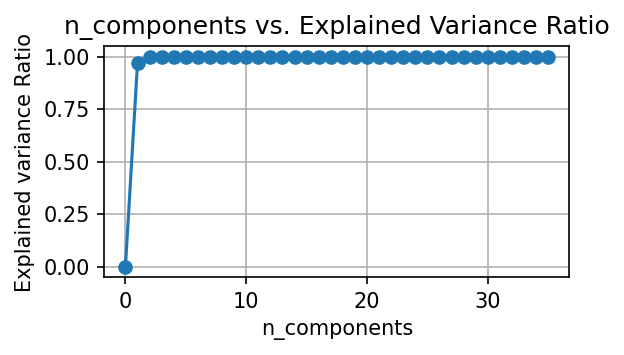

In [19]:
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance Ratio')
plt.title('n_components vs. Explained Variance Ratio')

LASSO PCA

In [20]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

# fit model
Lasso_model_PCA = model.fit(X_train_pca, y_train)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)
array = np.where(abs(Lasso_model_PCA.coef_) >0)
print(array)
print("Variables Selected:")
print(X.iloc[:, [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]].columns)
print("Variable Coefficients:")
print(Lasso_model_PCA.coef_)

alpha: 0.000000
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64),)
Variables Selected:
Index(['Liked_By_Members', 'Quality_Of_Life_Score', 'Family_Score',
       'Community_Score', 'Cost', 'Internet', 'Fun', 'Humidity_now',
       'Air_Quality_Now', 'Air_Quality_Annual', 'Safety', 'Food_Safety',
       'Lack_Of_Crime', 'Lack_Of_Racism', 'Education_Level', 'Power_Grid',
       'Vulnerability_To_Climate_Change', 'Income_Level', 'English_Speaking',
       'People_Density', 'Walkability', 'Peace', 'Traffic_Safety', 'Hospitals',
       'Happiness', 'Nightlife', 'Free_Wifi_In_City', 'Places_To_Work_From',
       'AC_Or_Heating', 'Friendly_To_Foreigners', 'Freedom_Of_Speech',
       'Female_Friendly', 'LGBTQ_Friendly'],
      dtype='object')
Variable Coefficients:
[-6.89600184e-05  1.89121257e-03 -3.70991111e-02  3.11080149e-02
  1.20169344e-02 -1.32257775e-02  2.05920281e-02 

In [21]:
y_pred = Lasso_model_PCA.predict(X_test_pca)
Lasso_PCA_mse = mean_squared_error(y_test, y_pred)
Lasso_PCA_mae = mean_absolute_error(y_test, y_pred)
Lasso_PCA_r2 = r2_score(y_test, y_pred)

print(Lasso_PCA_mse)
print(Lasso_PCA_mae)
print(Lasso_PCA_r2)
result = {'model': "PCA Lasso", 'MSE': Lasso_PCA_mse, 'MAE': Lasso_PCA_mae, 'R^2': Lasso_PCA_r2}
Model_results.append(result)

0.06387118843205176
0.17891692171099227
0.6263259802453638


Ridge PCA

In [22]:
# list of alphas to check: 100 values from 0 to 5 with
r_alphas = np.logspace(0, 5, 100)

# initiate the cross validation over alphas
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2')

# fit the model with the best alpha
ridge_model_PCA = ridge_model.fit(X_train_pca, y_train)

In [23]:
y_pred = ridge_model_PCA.predict(X_test_pca)
Ridge_PCA_mse = mean_squared_error(y_test, y_pred)
Ridge_PCA_mae = mean_absolute_error(y_test, y_pred)
Ridge_PCA_r2 = r2_score(y_test, y_pred)

print(Ridge_PCA_mse)
print(Ridge_PCA_mae)
print(Ridge_PCA_r2)
result = {'model': "PCA Ridge", 'MSE': Ridge_PCA_mse, 'MAE': Ridge_PCA_mae, 'R^2': Ridge_PCA_r2}
Model_results.append(result)

0.06395755218470808
0.18711700050207525
0.6258207150168874


Elastic Net PCA

In [24]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
ElasticNet_model_PCA = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

# fit model
ElasticNet_model_PCA.fit(X_train_pca, y_train)

# summarize chosen configuration
print('alpha: %f' % ElasticNet_model_PCA.alpha_)
print('l1_ratio_: %f' % ElasticNet_model_PCA.l1_ratio_)
array = np.where(abs(ElasticNet_model_PCA.coef_) >0)
print("Variables Selected:")
print(X.iloc[:, [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]].columns)
print("Variable Coefficients:")
print(ElasticNet_model_PCA.coef_)

alpha: 0.010000
l1_ratio_: 0.390000
Variables Selected:
Index(['Liked_By_Members', 'Quality_Of_Life_Score', 'Family_Score',
       'Community_Score', 'Cost', 'Internet', 'Fun', 'Humidity_now',
       'Air_Quality_Now', 'Air_Quality_Annual', 'Safety', 'Food_Safety',
       'Lack_Of_Crime', 'Lack_Of_Racism', 'Education_Level', 'Power_Grid',
       'Vulnerability_To_Climate_Change', 'Income_Level', 'English_Speaking',
       'People_Density', 'Walkability', 'Peace', 'Traffic_Safety', 'Hospitals',
       'Happiness', 'Nightlife', 'Free_Wifi_In_City', 'Places_To_Work_From',
       'AC_Or_Heating', 'Friendly_To_Foreigners', 'Freedom_Of_Speech',
       'Female_Friendly', 'LGBTQ_Friendly'],
      dtype='object')
Variable Coefficients:
[-6.87535583e-05  1.88441366e-03 -3.60985267e-02  2.97033464e-02
  9.81974005e-03 -1.09529606e-02  1.80473998e-02  4.45107453e-02
 -4.55856416e-02  4.67638687e-02  6.55031101e-03  8.01713036e-02
 -1.16897903e-02 -1.63419025e-01 -5.39321835e-03  1.33571829e-01
  6

In [25]:
y_pred = ElasticNet_model.predict(X_test)
ElasticNet_PCA_mse = mean_squared_error(y_test, y_pred)
ElasticNet_PCA_mae = mean_absolute_error(y_test, y_pred)
ElasticNet_PCA_r2 = r2_score(y_test, y_pred)

print('MSE: ', ElasticNet_PCA_mse)
print('MAE: ', ElasticNet_PCA_mae)
print('R^2: ', ElasticNet_PCA_r2)
result = {'model': "PCA Elastic Net", 'MSE': ElasticNet_PCA_mse, 'MAE': ElasticNet_PCA_mae, 'R^2': ElasticNet_PCA_r2}
Model_results.append(result)

MSE:  0.05825083687639686
MAE:  0.17455594601909807
R^2:  0.6592074626444275


In [26]:
evaluation_df = pd.DataFrame(Model_results)
evaluation_df

,model,MSE,MAE,R^2
0,Lasso,0.058528,0.179649,0.657586
1,Ridge,0.064122,0.181840,0.624860
2,Elastic Net,0.058251,0.174556,0.659207
3,PCA Lasso,0.063871,0.178917,0.626326
4,PCA Ridge,0.063958,0.187117,0.625821
5,PCA Elastic Net,0.058251,0.174556,0.659207
